# Load data

In [1]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = dsets.CIFAR10('../data/', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../data/', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# Import  Models A
----

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os.path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from copy import deepcopy
from resnet import ResNet18

In [4]:
# Select device
# device = torch.device('cuda')
device = torch.device('cuda:0')

## Import  model A

In [5]:
# Check for model
if os.path.isfile('models/cifar resnet.pt'):
    # Load saved model
    print('Loading saved model')
    model_A = torch.load('models/cifar resnet.pt').to(device)
else:
    print('Model not available')

Loading saved model


## Import surrogate A

In [7]:
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

In [8]:
# Check for model
if os.path.isfile('models/cifar surrogate.pt'):
    print('Loading saved surrogate model')
    surr_A = torch.load('models/cifar surrogate.pt').to(device)
    surrogate_A = ImageSurrogate(surr_A, width=32, height=32, superpixel_size=2)

else:
    print('Model not available')

Loading saved surrogate model


## Import Explainer A

In [9]:
from unet import UNet
from fastshap import FastSHAP

In [10]:
# Check for model
if os.path.isfile('./models/cifar explainer.pt'):
    print('Loading saved explainer model')
    explainer_A = torch.load('./models/cifar explainer.pt').to(device)
    fastshap_A = FastSHAP(explainer_A, surrogate_A, link=nn.LogSoftmax(dim=1))

else:
    print('Model not available')

Loading saved explainer model


# Import Models B
-----

## Import Model B

In [11]:
from vit import ViT
model_path = './models/cifar_c10_vit_aa_ls.pt'

In [12]:
if os.path.isfile(model_path):
    # load saved model
    print("Loading saved model")
    model_B = torch.load(model_path).to(device)
else:
    print('Model not available')

Loading saved model


In [13]:
# torch.save(model_B.cpu(), model_path)

## Import surrogates B

In [14]:
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, DatasetInputOnly, KLDivLoss

In [15]:
surr_model_path = './models/cifar_c10_vit_surrogate_lb20.pt'

In [16]:
# Check for model
if os.path.isfile(surr_model_path):
    print('Loading saved surrogate model')
    surr_B = torch.load(surr_model_path).to(device)
    surrogate_B = ImageSurrogate(surr_B, width=32, height=32, superpixel_size=2)
else:
    print('Model not available')

Loading saved surrogate model


## Import explainer B

In [17]:
from unet import UNet
from fastshap import FastSHAP

In [18]:
explainer_path = './models/cifar_explainer_unet_lb20.pt'

In [19]:
# Check for model
if os.path.isfile(explainer_path):
    print('Loading saved explainer model')
    explainer_B = torch.load(explainer_path).to(device)
    fastshap_B = FastSHAP(explainer_B, surrogate_B, link=nn.LogSoftmax(dim=1))

else:
    print('Model not available')

Loading saved explainer model


# Initialize dataset

In [20]:
dset = val_set
dset_size = len(val_set)
# dset_size = 10
targets = np.array(dset.targets)
num_classes = targets.max() + 1
classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [58]:
dset_size

10000

# Plot individual images and values

In [21]:
import matplotlib.pyplot as plt

In [22]:
def plot_img(x):
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x.numpy() * std + mean    
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    plt.imshow(im, vmin=0, vmax=1)
    plt.show()

In [23]:
def plot_values(value):
#     plt.imshow(value, cmap='seismic',vmin=-m, vmax=m )
    plt.imshow(value, cmap='seismic')

In [24]:
model_A.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): ModuleList(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): Bat

In [25]:
model_B.eval()

ViT(
  (emb): Linear(in_features=48, out_features=384, bias=True)
  (enc): Sequential(
    (0): TransformerEncoder(
      (la1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (msa): MultiHeadSelfAttention(
        (q): Linear(in_features=384, out_features=384, bias=True)
        (k): Linear(in_features=384, out_features=384, bias=True)
        (v): Linear(in_features=384, out_features=384, bias=True)
        (o): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (la2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=384, out_features=384, bias=True)
        (1): GELU()
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=384, out_features=384, bias=True)
        (4): GELU()
        (5): Dropout(p=0.0, inplace=False)
      )
    )
    (1): TransformerEncoder(
      (la1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)

# Collect data

## Create dataframe to store results

In [26]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)

In [27]:
columns =  ['y_label','y_A','y_prob_correct_A', 'y_prob_A', 'A','y_B','y_prob_correct_B', 'y_prob_B', 'B']
dset_idxs = np.array(range(dset_size))
results = pd.DataFrame(columns = columns, index = dset_idxs)

In [28]:
results.head()

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Collect data 

In [29]:
def get_pred(dset, dset_size, idx, model, model_name, x, y):
    y_pred = model(x.to(device)).softmax(dim=1).detach().cpu()
    y_pred_class = np.argmax(y_pred)

    # store values
    results.iloc[idx]['y_' + model_name] = y_pred_class.item()
    results.iloc[idx]['y_prob_correct_' + model_name] = y_pred[0][y].item()
    results.iloc[idx]['y_prob_' + model_name] = y_pred[0][y_pred_class.item()].item()

    if (y == y_pred_class.item()): 
        results.iloc[idx][model_name] = 1
    else:
        results.iloc[idx][model_name] = 0

In [30]:
def collect_data(dset, dset_size, results, model_A, model_B):
    for idx in range(dset_size):
        x, y = zip(*[dset[idx]])
        x = torch.stack(x)
        y = y[0]
        
        results.iloc[idx]['y_label'] = y
        get_pred(dset, dset_size, idx, model_A, 'A', x, y)
        get_pred(dset, dset_size, idx, model_B, 'B', x, y)

In [31]:
def check_results(idx,  results, model_name):
    x, y = zip(*[dset[idx]])
    x = x[0]
    y = y[0]
    print(f'Label = {classes[y]}, {y}')
    y_predicted = results.iloc[idx]['y_' + model_name] 
    print(f'Predicted = {classes[y_predicted]} , {y_predicted}' )
    plot_img(x)

In [32]:
collect_data(dset, dset_size, results, model_A, model_B)

# Classify samples into sets


In [33]:
A_wrong_B_wrong = results[(results['A'] == 0) & (results['B'] == 0)] 

In [34]:
A_wrong_B_correct = results[(results['A'] == 0) & (results['B'] == 1)] 

In [35]:
A_correct_B_wrong = results[(results['A'] == 1) & (results['B'] == 0)] 

In [36]:
A_correct_B_correct = results[(results['A'] == 1) & (results['B'] == 1)] 

In [37]:
len(A_wrong_B_wrong)

347

In [38]:
len(A_correct_B_correct)

8732

In [39]:
len(A_correct_B_wrong)

593

In [40]:
len(A_wrong_B_correct)

328

In [41]:
5785+3275+166+774

10000

In [42]:
A_wrong_B_wrong.head()

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
52,0,3,0.000007,0.984527,0,3,0.153317,0.50464,0
59,6,3,0.284976,0.715013,0,1,0.024262,0.714644,0
61,3,5,0.000006,0.999994,0,5,0.015741,0.902624,0
78,3,5,0.093655,0.906292,0,5,0.086768,0.820117,0
164,8,0,0.029999,0.969361,0,0,0.029478,0.826091,0


In [43]:
A_wrong_B_correct.head()

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
2,8,1,0.252557,0.747433,0,8,0.908762,0.908762,1
46,3,6,0.031141,0.968708,0,3,0.893399,0.893399,1
47,9,8,0.408819,0.589458,0,9,0.868146,0.868146,1
58,4,5,0.031468,0.965946,0,4,0.325183,0.325183,1
118,2,6,0.000419,0.998847,0,2,0.82564,0.82564,1


In [44]:
A_correct_B_wrong.head()

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
9,1,1,0.999961,0.999961,1,9,0.350909,0.544917,0
35,2,2,0.995263,0.995263,1,3,0.044882,0.783589,0
53,3,3,1.0,1.0,1,4,0.135639,0.428918,0
57,7,7,1.0,1.0,1,5,0.010545,0.707665,0
68,3,3,0.999217,0.999217,1,4,0.039366,0.881701,0


In [45]:
A_correct_B_correct.head()

,y_label,y_A,y_prob_correct_A,y_prob_A,A,y_B,y_prob_correct_B,y_prob_B,B
0,3,3,1.0,1.0,1,3,0.890347,0.890347,1
1,8,8,1.0,1.0,1,8,0.902345,0.902345,1
3,0,0,0.999999,0.999999,1,0,0.913182,0.913182,1
4,6,6,1.0,1.0,1,6,0.911364,0.911364,1
5,6,6,1.0,1.0,1,6,0.886415,0.886415,1


# Check individual Results
----

In [46]:
# Sample indices for each category
idx_A_wrong_B_wrong = 52
idx_A_wrong_B_correct = 2 
idx_A_correct_B_wrong = 9
idx_A_correct_B_correct = 0

## Sample: A_wrong_B_wrong

Label = Airplane, 0
Predicted = Cat , 3


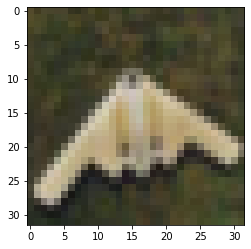

In [47]:
check_results(idx_A_wrong_B_wrong, results, 'A')

Label = Airplane, 0
Predicted = Cat , 3


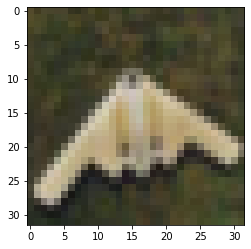

In [48]:
check_results(idx_A_wrong_B_wrong, results, 'B')

## Sample: A_wrong_B_correct

Label = Ship, 8
Predicted = Car , 1


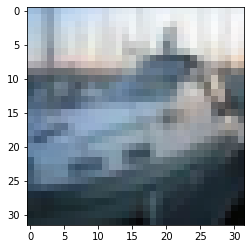

In [49]:
check_results(idx_A_wrong_B_correct, results, 'A')

Label = Ship, 8
Predicted = Ship , 8


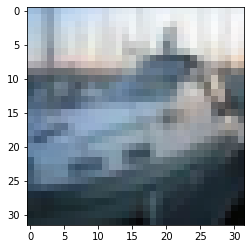

In [50]:
check_results(idx_A_wrong_B_correct, results, 'B')

## Sample: A_correct_B_wrong

Label = Car, 1
Predicted = Car , 1


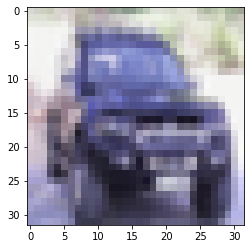

In [51]:
check_results(idx_A_correct_B_wrong, results, 'A')

Label = Car, 1
Predicted = Truck , 9


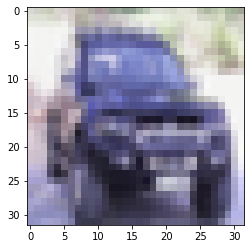

In [52]:
check_results(idx_A_correct_B_wrong, results, 'B')

## Sample: A_correct_B_correct

Label = Cat, 3
Predicted = Cat , 3


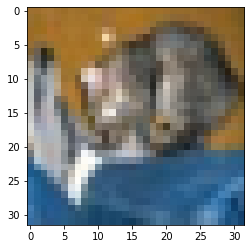

In [53]:
check_results(idx_A_correct_B_correct, results, 'A')

Label = Cat, 3
Predicted = Cat , 3


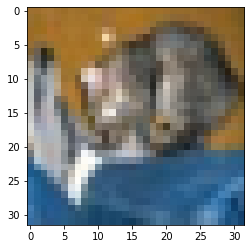

In [54]:
check_results(idx_A_correct_B_correct, results, 'B')

# Check explanations
----

In [55]:
def visualize_all_classes(model, surrogate, fastshap):
    # Select one image from each class
    dset = val_set
    targets = np.array(dset.targets)
    num_classes = targets.max() + 1
    inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
    inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
    x, y = zip(*[dset[ind] for ind in inds])
    x = torch.stack(x)

    # Get explanations
    values = fastshap.shap_values(x.to(device))

    # Get predictions
    pred = surrogate(
        x.to(device),
        torch.ones(num_classes, surrogate.num_players, device=device)
    ).softmax(dim=1).cpu().data.numpy()

    fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

    for row in range(num_classes):
        # Image
        classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
        mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
        std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
        im = x[row].numpy() * std + mean
        im = im.transpose(1, 2, 0).astype(float)
        im = np.clip(im, a_min=0, a_max=1)
        axarr[row, 0].imshow(im, vmin=0, vmax=1)
        axarr[row, 0].set_xticks([])
        axarr[row, 0].set_yticks([])
        axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)

        # Explanations
        m = np.abs(values[row]).max()
        for col in range(num_classes):
            axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
            axarr[row, col + 1].set_xticks([])
            axarr[row, col + 1].set_yticks([])
            if col == y[row]:
                axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
            else:
                axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)

            # Class labels
            if row == 0:
                axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

    plt.tight_layout()
    plt.show()

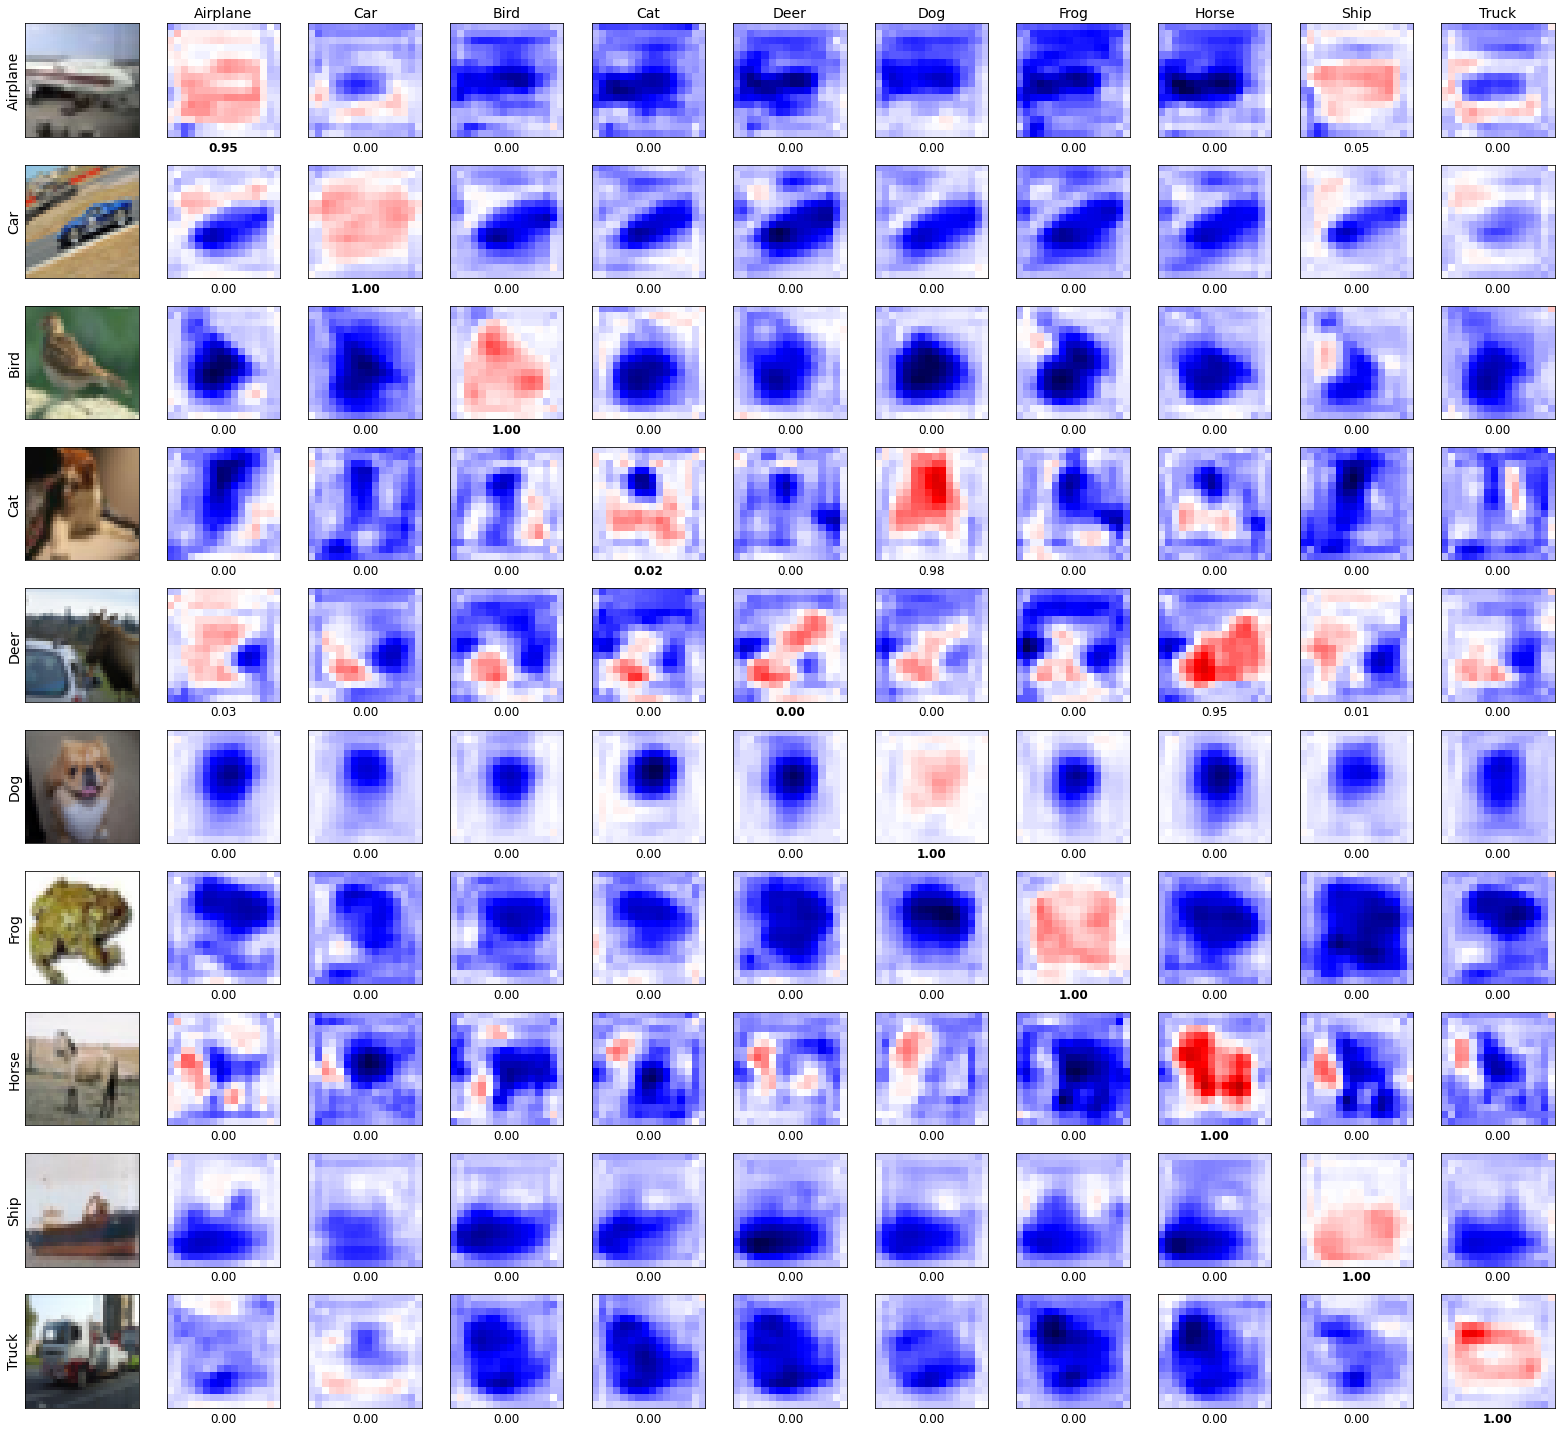

In [56]:
visualize_all_classes(model_A, surrogate_A, fastshap_A)

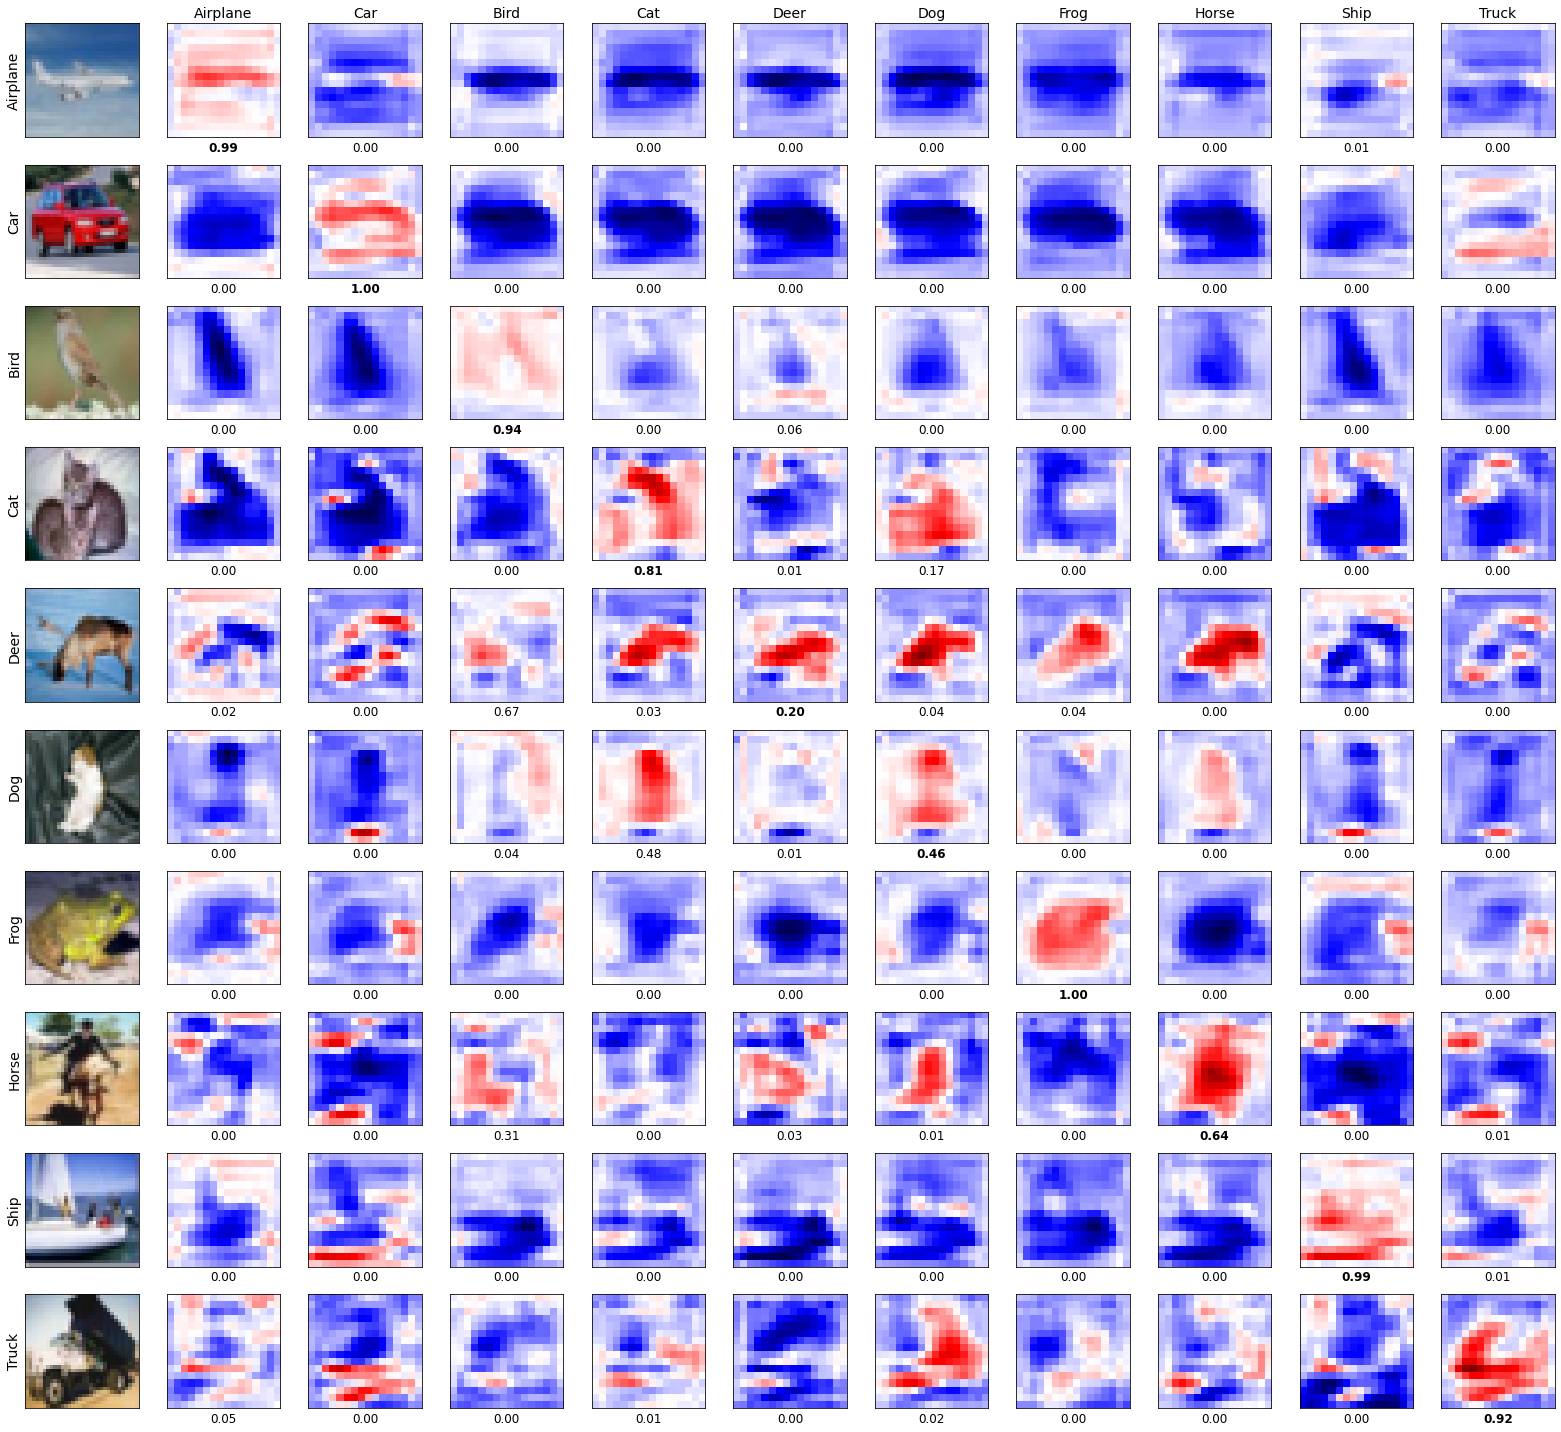

In [57]:
visualize_all_classes(model_B, surrogate_B, fastshap_B)

In [60]:
def visualize_one_sample(idx, model, surrogate, fastshap):
    # Select one image from each class
    dset = val_set
    targets = np.array(dset.targets)
    num_classes = targets.max() + 1
    x, y = zip(*[dset[idx]])
    x = torch.stack(x)

    # Get explanations
    values = fastshap.shap_values(x.to(device))

    # Get predictions
    pred = surrogate(
        x.to(device),
        torch.ones(num_classes, surrogate.num_players, device=device)
    ).softmax(dim=1).cpu().data.numpy()
    
    # Get model predictions
    y_pred = model(x.to(device)).softmax(dim=1).detach().cpu()
    y_pred_class = np.argmax(y_pred)

#     fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))
    fig, axarr = plt.subplots(1, num_classes + 1, figsize=(22, 2))
    row = 0
    
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[0].imshow(im, vmin=0, vmax=1)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)

    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[col + 1].set_xticks([])
        axarr[col + 1].set_yticks([])
        if col == y_pred_class:
#             axarr[col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
              axarr[col + 1].set_xlabel('M = {:.2f} , S = {:.2f}'.format(y_pred[0][col], pred[row, col]), fontsize=12, fontweight='bold')
        else:
#             axarr[col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
            axarr[col + 1].set_xlabel('M = {:.2f} , S = {:.2f}'.format(y_pred[0][col], pred[row, col]), fontsize=12)
        
        axarr[col + 1].set_title('{}'.format(classes[col]), fontsize=14)

    plt.tight_layout()
    plt.show()

## Visualize: A_wrong_B_wrong

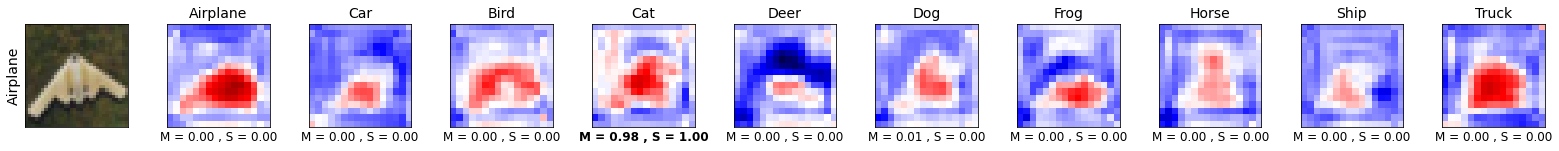

In [61]:
visualize_one_sample(idx_A_wrong_B_wrong, model_A, surrogate_A, fastshap_A)

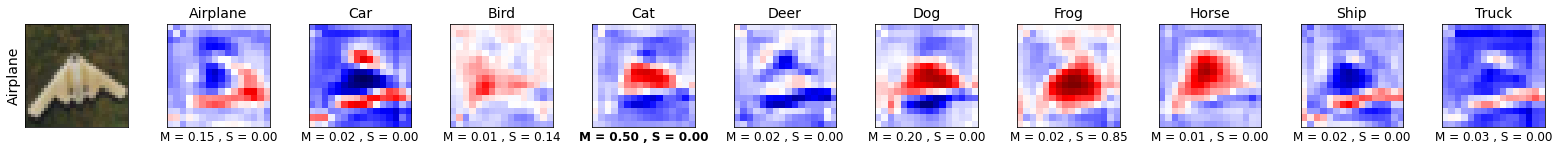

In [62]:
visualize_one_sample(idx_A_wrong_B_wrong, model_B, surrogate_B, fastshap_B)

## Visualize: A_wrong_B_correct

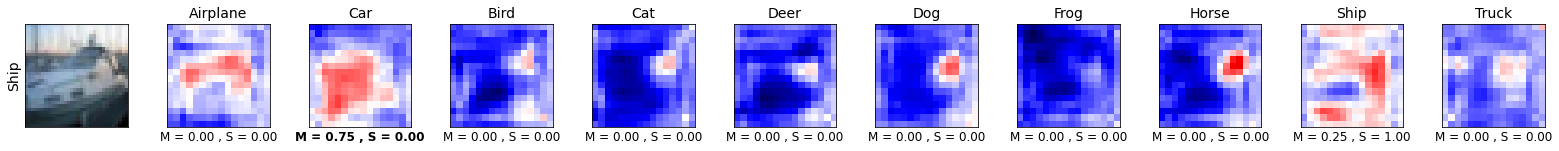

In [63]:
visualize_one_sample(idx_A_wrong_B_correct, model_A, surrogate_A, fastshap_A)

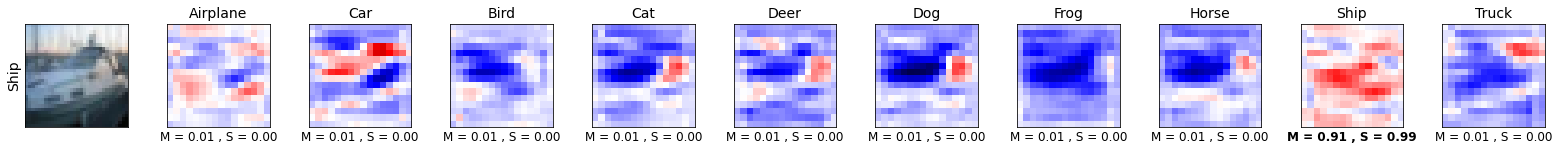

In [64]:
visualize_one_sample(idx_A_wrong_B_correct, model_B, surrogate_B, fastshap_B)

## Visualize: A_correct_B_wrong

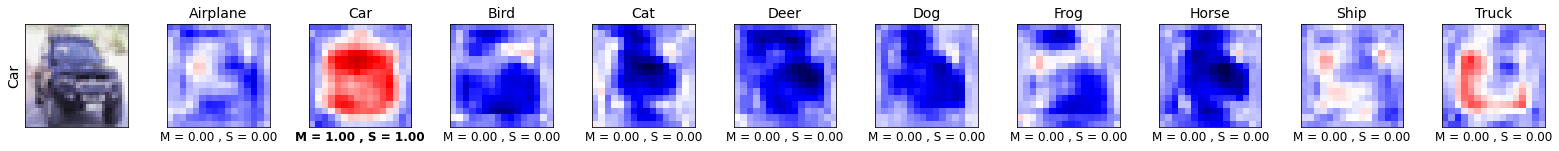

In [65]:
visualize_one_sample(idx_A_correct_B_wrong, model_A, surrogate_A, fastshap_A)

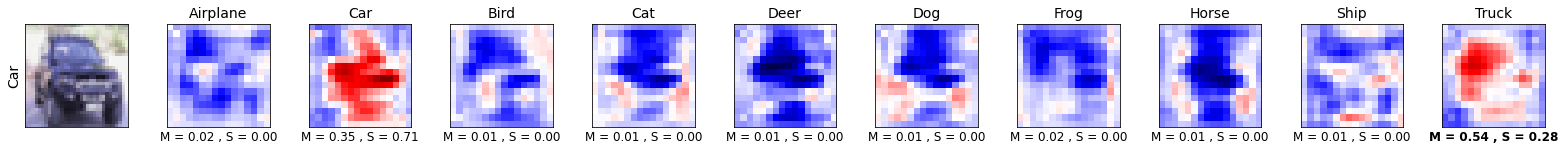

In [66]:
visualize_one_sample(idx_A_correct_B_wrong, model_B, surrogate_B, fastshap_B)

## Visualize: A_correct_B_correct

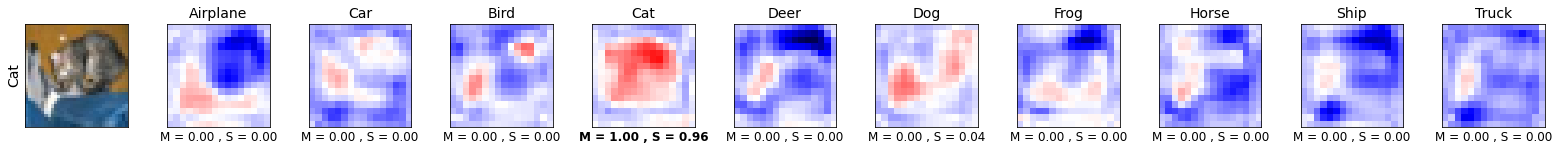

In [67]:
visualize_one_sample(idx_A_correct_B_correct, model_A, surrogate_A, fastshap_A)

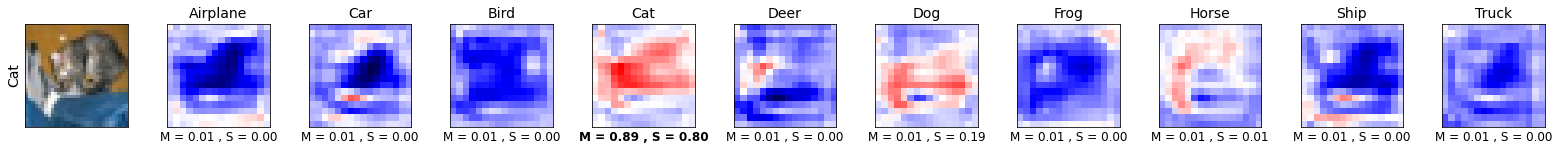

In [68]:
visualize_one_sample(idx_A_correct_B_correct, model_B, surrogate_B, fastshap_B)